Classification pipeline from cuts to decision tree 

1. plot q2 vs invariant mass
2. do hard cuts (from literature, investigate whether other cuts are necessary) 
3. apply hard cuts on simulated data 
4. train GBDT on simulated data 
5. classify hard-cut data (total_dataset and acceptance)
6. investigate fraction of misclassified decays 

## import modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import pickle
from collections import defaultdict

In [3]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
def hist_point(a, bins, range=None, *args, **kwargs):
    # histogram but plot as scatterplot 
    hist, bin_edges = np.histogram(a, bins=bins, range=range)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.scatter(bin_centres, hist, *args, **kwargs)

## import data

In [5]:
data_path = '../data/'

total_path = f'{data_path}total_dataset.pkl'
signal_path = f'{data_path}signal.pkl'
jpsi_path = f'{data_path}jpsi.pkl' 
psi2S_path = f'{data_path}psi2S.pkl' 
jpsi_mu_k_swap_path = f'{data_path}jpsi_mu_k_swap.pkl' 
jpsi_mu_pi_swap_path = f'{data_path}jpsi_mu_pi_swap.pkl' 
k_pi_swap_path = f'{data_path}k_pi_swap.pkl' 
phimumu_path = f'{data_path}phimumu.pkl' 
pKmumu_piTok_kTop_path = f'{data_path}pKmumu_piTok_kTop.pkl' 
pKmumu_piTop_path = f'{data_path}pKmumu_piTop.pkl' 

In [6]:
total_dataset      = pd.read_pickle(total_path)
signal             = pd.read_pickle(signal_path)
jpsi               = pd.read_pickle(jpsi_path)
psi2S              = pd.read_pickle(psi2S_path)
jpsi_mu_k_swap     = pd.read_pickle(jpsi_mu_k_swap_path)
jpsi_mu_pi_swap    = pd.read_pickle(jpsi_mu_pi_swap_path)
k_pi_swap          = pd.read_pickle(k_pi_swap_path)
phimumu            = pd.read_pickle(phimumu_path)
pKmumu_piTok_kTop  = pd.read_pickle(pKmumu_piTok_kTop_path)
pKmumu_piTop       = pd.read_pickle(pKmumu_piTop_path)

In [7]:
all_datasets = [total_dataset, signal, jpsi, psi2S, jpsi_mu_k_swap, jpsi_mu_pi_swap, 
                    k_pi_swap, phimumu, pKmumu_piTok_kTop, pKmumu_piTop]
all_names = ['Total', 'Signal', 'J/Psi', 'Psi(2S)', 'J/Psi_mu/k', 'J/Psi_mu/pi', 
            'K0_k/pi', 'Phi_mu_mu', 'pK_pi/K_k/pi', 'pK_p/pi']

## general information

Total has 	 498245 datapoints
Signal has 	 255741 datapoints
J/Psi has 	 786776 datapoints
Psi(2S) has 	 181076 datapoints
J/Psi_mu/k has 	 1986 datapoints
J/Psi_mu/pi has 	 773 datapoints
K0_k/pi has 	 133292 datapoints
Phi_mu_mu has 	 68318 datapoints
pK_pi/K_k/pi has 	 1447 datapoints
pK_p/pi has 	 1127 datapoints


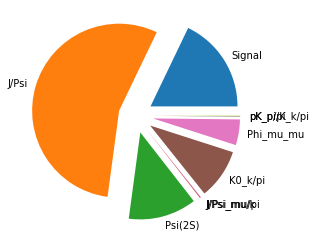

In [8]:
for name, data in zip(all_names, all_datasets):
    print(f'{name} has \t {len(data)} datapoints')

plt.pie([len(d) for d in all_datasets[1:]], labels=all_names[1:], explode=[0.2]*(len(all_datasets)-1));

## initial plots

In [9]:
def plot_q2_m_inv(data, set_range=True):
    if set_range:
        m_inv_range = [np.percentile(data['B0_MM'], 1), np.percentile(data['B0_MM'], 99)]
        q2_range = [0, 20]
        print('m_inv range', m_inv_range)
        print('q2_range', q2_range)
        
    h, x_edges, y_edges, _ = plt.hist2d(data['B0_MM'], data['q2'], 
                                        bins=100, range=[m_inv_range, q2_range] if set_range else None,
                                        norm=mpl.colors.LogNorm())

    plt.xlabel(r'$m(K^+ \pi^- \mu^+ \mu^-)$ [MeV/$c^2$]')
    plt.ylabel(r'$q^2$ [$GeV^2/c^4$]')
    

def plot_q2_mK0(data, set_range=True):
    if set_range:
        m_inv_range = [np.percentile(data['Kstar_MM'], 1), np.percentile(data['Kstar_MM'], 99)]
        q2_range = [0, 20]
        print('m(Kstar) range', m_inv_range)
        print('q2_range', q2_range)
        
    h, x_edges, y_edges, _ = plt.hist2d(data['Kstar_MM'], data['q2'], 
                                        bins=100, range=[m_inv_range, q2_range] if set_range else None,
                                        norm=mpl.colors.LogNorm())

    plt.xlabel(r'$m(K^{*0})$ [MeV/$c^2$]')
    plt.ylabel(r'$q^2$ [$GeV^2/c^4$]')

m_inv range [5173.623210452642, 5656.614283847155]
q2_range [0, 20]


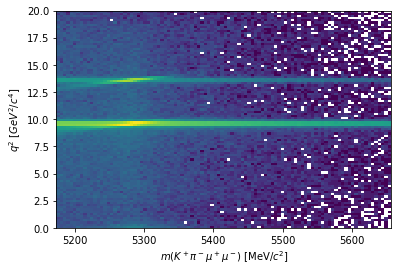

In [10]:
plot_q2_m_inv(total_dataset)

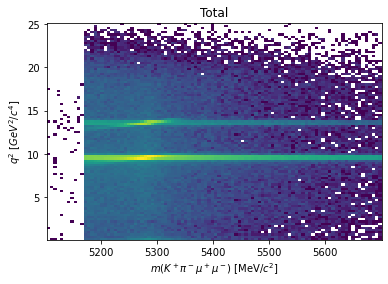

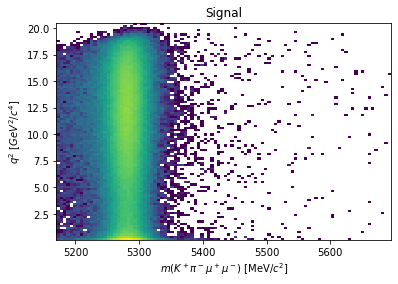

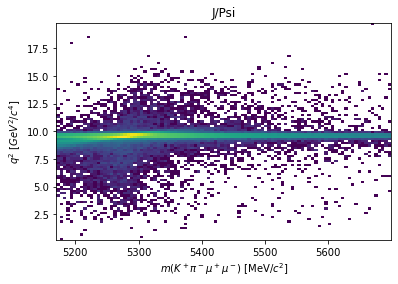

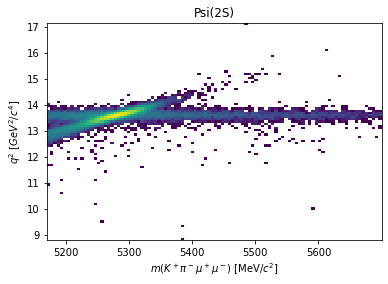

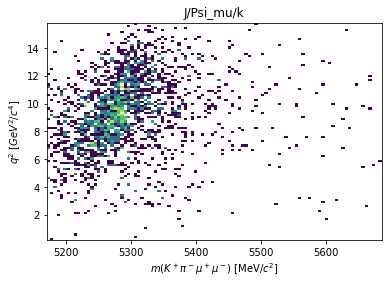

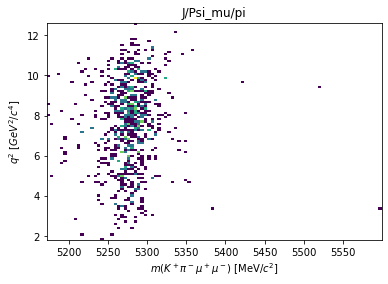

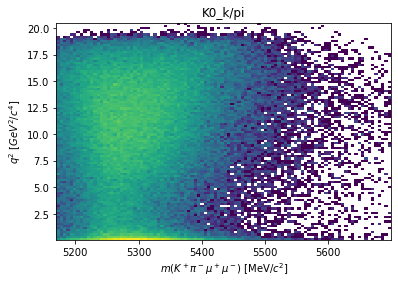

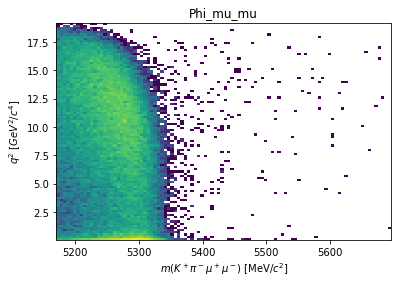

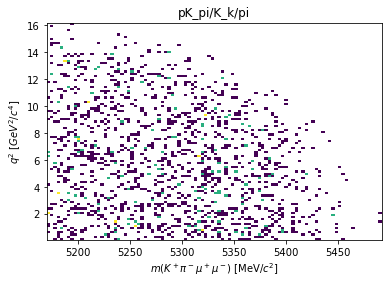

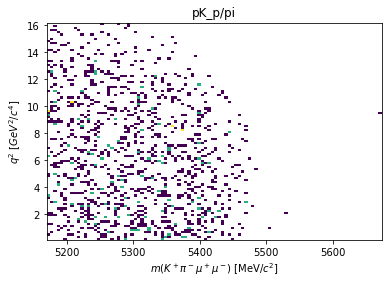

In [11]:
for name, data in zip(all_names, all_datasets):
    plot_q2_m_inv(data, set_range=False)
    plt.title(name)
    plt.show()

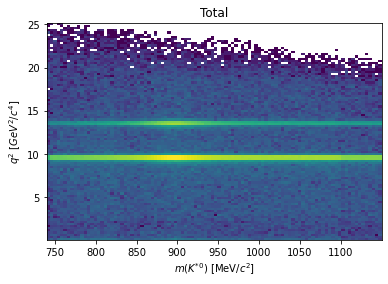

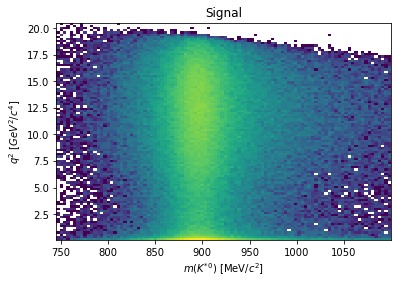

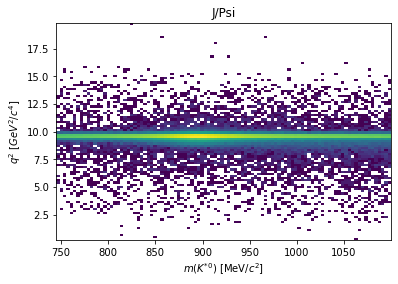

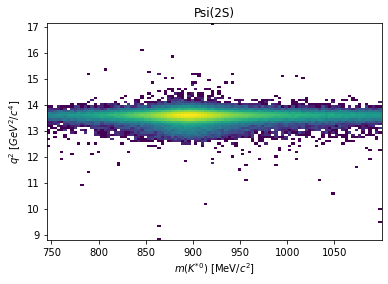

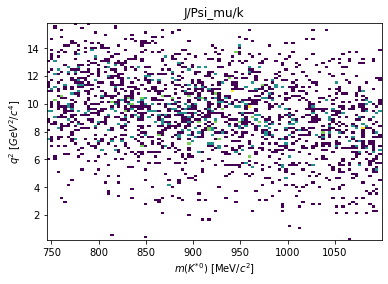

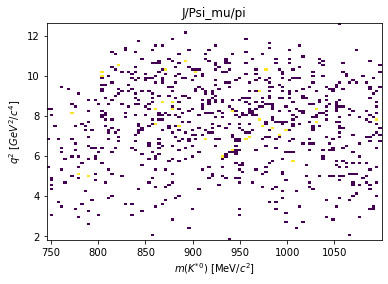

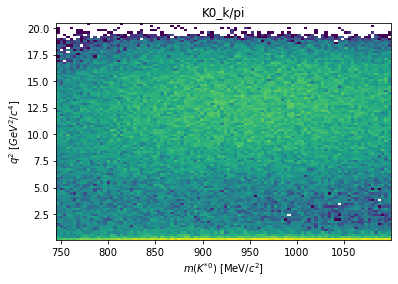

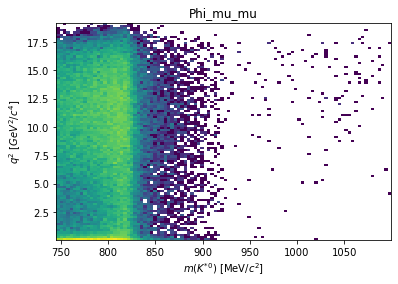

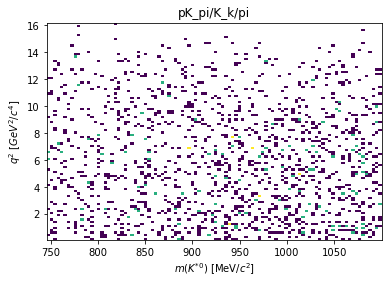

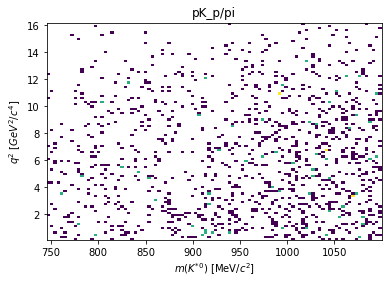

In [12]:
for name, data in zip(all_names, all_datasets):
    plot_q2_mK0(data, set_range=False)
    plt.title(name)
    plt.show()

Above plots show potential cuts and regions where specific decays are located. It is clear that most of J/Psi and Psi(2S) can be removed by cuts in q2. 

## hard cuts 

The following cuts were created by Zhihao Zhang

1. explain specific hard cut 
2. plot effect on q2 vs m_inv
3. quantify reduction in samples 
4. apply cut to total_dataset

In [13]:
from selection_criteria.functions import selection_1, selection_2, selection_3, selection_4, selection_5, selection_6

In [14]:
def benchmark_cut(cut_func):
    for name, data in zip(all_names, all_datasets):
        N_before = len(data)
        data_cut = cut_func(data)
        N_after = len(data_cut)
        
        name_space = "".join([" "]*(12-len(name)))
        N_diff = N_before - N_after
        N_frac = N_diff / N_before
        print(f'{name}{name_space} reduced by {N_frac*100:.2f}% or {N_diff} samples \tfrom {N_before} to {N_after}')

### selection 1

P(mu/K/pi == mu/K/pi) > 0.5 (non-optimised)

goal: keep reduction in signal <0.5%

In [15]:
# original, all 0.5
benchmark_cut(selection_1)

Total        reduced by 66.00% or 328857 samples 	from 498245 to 169388
Signal       reduced by 17.46% or 44643 samples 	from 255741 to 211098
J/Psi        reduced by 47.80% or 376074 samples 	from 786776 to 410702
Psi(2S)      reduced by 17.35% or 31416 samples 	from 181076 to 149660
J/Psi_mu/k   reduced by 99.75% or 1981 samples 	from 1986 to 5
J/Psi_mu/pi  reduced by 97.80% or 756 samples 	from 773 to 17
K0_k/pi      reduced by 99.77% or 132989 samples 	from 133292 to 303
Phi_mu_mu    reduced by 96.12% or 65668 samples 	from 68318 to 2650
pK_pi/K_k/pi reduced by 98.55% or 1426 samples 	from 1447 to 21
pK_p/pi      reduced by 96.18% or 1084 samples 	from 1127 to 43


In [16]:
# optimise mu
selection_1_modified = partial(selection_1, cutoff_mu=0.5, cutoff_K=0, cutoff_Pi=0)
benchmark_cut(selection_1_modified)

Total        reduced by 65.67% or 327184 samples 	from 498245 to 171061
Signal       reduced by 17.43% or 44565 samples 	from 255741 to 211176
J/Psi        reduced by 47.59% or 374436 samples 	from 786776 to 412340
Psi(2S)      reduced by 17.27% or 31278 samples 	from 181076 to 149798
J/Psi_mu/k   reduced by 99.80% or 1982 samples 	from 1986 to 4
J/Psi_mu/pi  reduced by 97.67% or 755 samples 	from 773 to 18
K0_k/pi      reduced by 99.77% or 132980 samples 	from 133292 to 312
Phi_mu_mu    reduced by 96.09% or 65644 samples 	from 68318 to 2674
pK_pi/K_k/pi reduced by 98.55% or 1426 samples 	from 1447 to 21
pK_p/pi      reduced by 96.18% or 1084 samples 	from 1127 to 43


In [17]:
# optimise K
selection_1_modified = partial(selection_1, cutoff_mu=0, cutoff_K=0.08, cutoff_Pi=0)
benchmark_cut(selection_1_modified)

Total        reduced by 65.64% or 327025 samples 	from 498245 to 171220
Signal       reduced by 17.24% or 44092 samples 	from 255741 to 211649
J/Psi        reduced by 47.47% or 373485 samples 	from 786776 to 413291
Psi(2S)      reduced by 17.13% or 31014 samples 	from 181076 to 150062
J/Psi_mu/k   reduced by 99.70% or 1980 samples 	from 1986 to 6
J/Psi_mu/pi  reduced by 97.67% or 755 samples 	from 773 to 18
K0_k/pi      reduced by 99.77% or 132981 samples 	from 133292 to 311
Phi_mu_mu    reduced by 96.07% or 65636 samples 	from 68318 to 2682
pK_pi/K_k/pi reduced by 98.55% or 1426 samples 	from 1447 to 21
pK_p/pi      reduced by 96.18% or 1084 samples 	from 1127 to 43


In [18]:
# optimise Pi
selection_1_modified = partial(selection_1, cutoff_mu=0, cutoff_K=0, cutoff_Pi=0.2)
benchmark_cut(selection_1_modified)

Total        reduced by 65.92% or 328460 samples 	from 498245 to 169785
Signal       reduced by 17.43% or 44570 samples 	from 255741 to 211171
J/Psi        reduced by 47.77% or 375863 samples 	from 786776 to 410913
Psi(2S)      reduced by 17.33% or 31372 samples 	from 181076 to 149704
J/Psi_mu/k   reduced by 99.70% or 1980 samples 	from 1986 to 6
J/Psi_mu/pi  reduced by 97.80% or 756 samples 	from 773 to 17
K0_k/pi      reduced by 99.77% or 132988 samples 	from 133292 to 304
Phi_mu_mu    reduced by 96.12% or 65664 samples 	from 68318 to 2654
pK_pi/K_k/pi reduced by 98.55% or 1426 samples 	from 1447 to 21
pK_p/pi      reduced by 96.18% or 1084 samples 	from 1127 to 43


In [19]:
# selection_1_modified = partial(selection_1, cutoff_mu=0.3, cutoff_K=0.02, cutoff_Pi=0.08)
selection_1_modified = partial(selection_1, cutoff_mu=0.5, cutoff_K=0.1, cutoff_Pi=0.4)
benchmark_cut(selection_1_modified)

Total        reduced by 66.77% or 332670 samples 	from 498245 to 165575
Signal       reduced by 18.45% or 47180 samples 	from 255741 to 208561
J/Psi        reduced by 48.70% or 383166 samples 	from 786776 to 403610
Psi(2S)      reduced by 18.31% or 33146 samples 	from 181076 to 147930
J/Psi_mu/k   reduced by 99.85% or 1983 samples 	from 1986 to 3
J/Psi_mu/pi  reduced by 98.06% or 758 samples 	from 773 to 15
K0_k/pi      reduced by 99.80% or 133028 samples 	from 133292 to 264
Phi_mu_mu    reduced by 96.43% or 65876 samples 	from 68318 to 2442
pK_pi/K_k/pi reduced by 98.69% or 1428 samples 	from 1447 to 19
pK_p/pi      reduced by 96.54% or 1088 samples 	from 1127 to 39


Summary: Seems pretty good, but also reduces the signal by a bit.

In [20]:
# selection_1_final = partial(selection_1, cutoff_mu=0.3, cutoff_K=0.02, cutoff_Pi=0.04)
# selection_1_final = partial(selection_1, cutoff_mu=0.5, cutoff_K=0.1, cutoff_Pi=0.4)
selection_1_final = partial(selection_1, cutoff_mu=0.3, cutoff_K=0.02, cutoff_Pi=0.2) # reduced severity of this cut

In [21]:
benchmark_cut(selection_1_final)

Total        reduced by 65.94% or 328547 samples 	from 498245 to 169698
Signal       reduced by 17.45% or 44620 samples 	from 255741 to 211121
J/Psi        reduced by 47.79% or 375982 samples 	from 786776 to 410794
Psi(2S)      reduced by 17.34% or 31404 samples 	from 181076 to 149672
J/Psi_mu/k   reduced by 99.75% or 1981 samples 	from 1986 to 5
J/Psi_mu/pi  reduced by 97.80% or 756 samples 	from 773 to 17
K0_k/pi      reduced by 99.77% or 132988 samples 	from 133292 to 304
Phi_mu_mu    reduced by 96.12% or 65667 samples 	from 68318 to 2651
pK_pi/K_k/pi reduced by 98.55% or 1426 samples 	from 1447 to 21
pK_p/pi      reduced by 96.18% or 1084 samples 	from 1127 to 43


### selection 2

DIRA angle > 1 - $\theta_\mathrm{thresh}^2 / 2$  

In [22]:
benchmark_cut(selection_2)

Total        reduced by 0.21% or 1060 samples 	from 498245 to 497185
Signal       reduced by 0.04% or 96 samples 	from 255741 to 255645
J/Psi        reduced by 0.05% or 429 samples 	from 786776 to 786347
Psi(2S)      reduced by 0.03% or 59 samples 	from 181076 to 181017
J/Psi_mu/k   reduced by 0.05% or 1 samples 	from 1986 to 1985
J/Psi_mu/pi  reduced by 0.00% or 0 samples 	from 773 to 773
K0_k/pi      reduced by 0.04% or 53 samples 	from 133292 to 133239
Phi_mu_mu    reduced by 0.05% or 31 samples 	from 68318 to 68287
pK_pi/K_k/pi reduced by 0.00% or 0 samples 	from 1447 to 1447
pK_p/pi      reduced by 0.00% or 0 samples 	from 1127 to 1127


In [23]:
selection_2_modified = partial(selection_2, threshold_angle=10e-3)
benchmark_cut(selection_2_modified)

Total        reduced by 8.12% or 40447 samples 	from 498245 to 457798
Signal       reduced by 2.03% or 5201 samples 	from 255741 to 250540
J/Psi        reduced by 2.71% or 21360 samples 	from 786776 to 765416
Psi(2S)      reduced by 2.18% or 3942 samples 	from 181076 to 177134
J/Psi_mu/k   reduced by 3.27% or 65 samples 	from 1986 to 1921
J/Psi_mu/pi  reduced by 1.81% or 14 samples 	from 773 to 759
K0_k/pi      reduced by 2.28% or 3033 samples 	from 133292 to 130259
Phi_mu_mu    reduced by 2.57% or 1756 samples 	from 68318 to 66562
pK_pi/K_k/pi reduced by 2.76% or 40 samples 	from 1447 to 1407
pK_p/pi      reduced by 2.13% or 24 samples 	from 1127 to 1103


Summary: does not seem to have any distinguishing power 

### selection 3

IP $\chi^2$ > threshold (non-B0)

In [24]:
benchmark_cut(selection_3)

Total        reduced by 2.58% or 12848 samples 	from 498245 to 485397
Signal       reduced by 1.49% or 3818 samples 	from 255741 to 251923
J/Psi        reduced by 1.67% or 13163 samples 	from 786776 to 773613
Psi(2S)      reduced by 0.82% or 1493 samples 	from 181076 to 179583
J/Psi_mu/k   reduced by 1.66% or 33 samples 	from 1986 to 1953
J/Psi_mu/pi  reduced by 1.55% or 12 samples 	from 773 to 761
K0_k/pi      reduced by 1.55% or 2070 samples 	from 133292 to 131222
Phi_mu_mu    reduced by 1.31% or 894 samples 	from 68318 to 67424
pK_pi/K_k/pi reduced by 1.59% or 23 samples 	from 1447 to 1424
pK_p/pi      reduced by 1.86% or 21 samples 	from 1127 to 1106


In [25]:
selection_3_modified = partial(selection_3, muon_IPchi2_threshold=9, hadron_IPchi2_threshold=6)
benchmark_cut(selection_3_modified)

Total        reduced by 2.58% or 12848 samples 	from 498245 to 485397
Signal       reduced by 1.49% or 3818 samples 	from 255741 to 251923
J/Psi        reduced by 1.67% or 13163 samples 	from 786776 to 773613
Psi(2S)      reduced by 0.82% or 1493 samples 	from 181076 to 179583
J/Psi_mu/k   reduced by 1.66% or 33 samples 	from 1986 to 1953
J/Psi_mu/pi  reduced by 1.55% or 12 samples 	from 773 to 761
K0_k/pi      reduced by 1.55% or 2070 samples 	from 133292 to 131222
Phi_mu_mu    reduced by 1.31% or 894 samples 	from 68318 to 67424
pK_pi/K_k/pi reduced by 1.59% or 23 samples 	from 1447 to 1424
pK_p/pi      reduced by 1.86% or 21 samples 	from 1127 to 1106


Summary: uniformly reduces, not great

### selection 4

IP $\chi^2$ > threshold (B0)

In [26]:
benchmark_cut(selection_4)

Total        reduced by 0.01% or 50 samples 	from 498245 to 498195
Signal       reduced by 0.00% or 0 samples 	from 255741 to 255741
J/Psi        reduced by 0.00% or 0 samples 	from 786776 to 786776
Psi(2S)      reduced by 0.00% or 0 samples 	from 181076 to 181076
J/Psi_mu/k   reduced by 0.00% or 0 samples 	from 1986 to 1986
J/Psi_mu/pi  reduced by 0.00% or 0 samples 	from 773 to 773
K0_k/pi      reduced by 0.00% or 0 samples 	from 133292 to 133292
Phi_mu_mu    reduced by 0.00% or 0 samples 	from 68318 to 68318
pK_pi/K_k/pi reduced by 0.00% or 0 samples 	from 1447 to 1447
pK_p/pi      reduced by 0.00% or 0 samples 	from 1127 to 1127


In [27]:
selection_4_modified = partial(selection_4, IPchi2_threshold=12)
benchmark_cut(selection_4_modified)

Total        reduced by 4.23% or 21078 samples 	from 498245 to 477167
Signal       reduced by 0.52% or 1323 samples 	from 255741 to 254418
J/Psi        reduced by 0.91% or 7153 samples 	from 786776 to 779623
Psi(2S)      reduced by 0.70% or 1262 samples 	from 181076 to 179814
J/Psi_mu/k   reduced by 1.01% or 20 samples 	from 1986 to 1966
J/Psi_mu/pi  reduced by 0.78% or 6 samples 	from 773 to 767
K0_k/pi      reduced by 0.51% or 682 samples 	from 133292 to 132610
Phi_mu_mu    reduced by 0.50% or 341 samples 	from 68318 to 67977
pK_pi/K_k/pi reduced by 0.48% or 7 samples 	from 1447 to 1440
pK_p/pi      reduced by 0.35% or 4 samples 	from 1127 to 1123


Summary: also not really worth it 

### selection 5

FD $\chi^2$ > threshold (ie. flight distance significant)

In [28]:
benchmark_cut(selection_5)

Total        reduced by 3.08% or 15364 samples 	from 498245 to 482881
Signal       reduced by 0.33% or 841 samples 	from 255741 to 254900
J/Psi        reduced by 0.47% or 3674 samples 	from 786776 to 783102
Psi(2S)      reduced by 0.33% or 595 samples 	from 181076 to 180481
J/Psi_mu/k   reduced by 0.45% or 9 samples 	from 1986 to 1977
J/Psi_mu/pi  reduced by 0.52% or 4 samples 	from 773 to 769
K0_k/pi      reduced by 0.34% or 449 samples 	from 133292 to 132843
Phi_mu_mu    reduced by 0.55% or 376 samples 	from 68318 to 67942
pK_pi/K_k/pi reduced by 0.62% or 9 samples 	from 1447 to 1438
pK_p/pi      reduced by 0.89% or 10 samples 	from 1127 to 1117


In [29]:
selection_5_modified = partial(selection_5, B0_FD_threshold=121, K_FD_threshold=18)
benchmark_cut(selection_5_modified)

Total        reduced by 4.41% or 21977 samples 	from 498245 to 476268
Signal       reduced by 0.57% or 1449 samples 	from 255741 to 254292
J/Psi        reduced by 0.73% or 5736 samples 	from 786776 to 781040
Psi(2S)      reduced by 0.64% or 1164 samples 	from 181076 to 179912
J/Psi_mu/k   reduced by 0.76% or 15 samples 	from 1986 to 1971
J/Psi_mu/pi  reduced by 0.91% or 7 samples 	from 773 to 766
K0_k/pi      reduced by 0.58% or 773 samples 	from 133292 to 132519
Phi_mu_mu    reduced by 0.99% or 676 samples 	from 68318 to 67642
pK_pi/K_k/pi reduced by 0.90% or 13 samples 	from 1447 to 1434
pK_p/pi      reduced by 1.06% or 12 samples 	from 1127 to 1115


Summary: not sure honestly, uniformly reduce too 

### selection 6

End vertex $\chi^2$ / ndof < threshold (good confidence in reconstructed vertex)

In [30]:
benchmark_cut(selection_6)

Total        reduced by 5.31% or 26432 samples 	from 498245 to 471813
Signal       reduced by 1.99% or 5083 samples 	from 255741 to 250658
J/Psi        reduced by 2.62% or 20589 samples 	from 786776 to 766187
Psi(2S)      reduced by 2.36% or 4270 samples 	from 181076 to 176806
J/Psi_mu/k   reduced by 3.17% or 63 samples 	from 1986 to 1923
J/Psi_mu/pi  reduced by 1.81% or 14 samples 	from 773 to 759
K0_k/pi      reduced by 1.98% or 2633 samples 	from 133292 to 130659
Phi_mu_mu    reduced by 2.22% or 1516 samples 	from 68318 to 66802
pK_pi/K_k/pi reduced by 1.38% or 20 samples 	from 1447 to 1427
pK_p/pi      reduced by 1.69% or 19 samples 	from 1127 to 1108


In [31]:
selection_6_modified = partial(selection_6, vertex_reduced_chi2_threshold=10)
benchmark_cut(selection_6_modified)

Total        reduced by 2.05% or 10194 samples 	from 498245 to 488051
Signal       reduced by 0.63% or 1616 samples 	from 255741 to 254125
J/Psi        reduced by 0.93% or 7299 samples 	from 786776 to 779477
Psi(2S)      reduced by 0.82% or 1485 samples 	from 181076 to 179591
J/Psi_mu/k   reduced by 0.91% or 18 samples 	from 1986 to 1968
J/Psi_mu/pi  reduced by 0.52% or 4 samples 	from 773 to 769
K0_k/pi      reduced by 0.64% or 854 samples 	from 133292 to 132438
Phi_mu_mu    reduced by 0.72% or 492 samples 	from 68318 to 67826
pK_pi/K_k/pi reduced by 0.41% or 6 samples 	from 1447 to 1441
pK_p/pi      reduced by 0.62% or 7 samples 	from 1127 to 1120


Summary: also doesn't distinguish

### selection 7

q2

In [32]:
from selection_criteria.functions import cut_data

In [33]:
# original: cut_q2 = [[0.98,1.10],[8.,11.],[12.5,15.]]
cut_q2 = [[0.98,1.10],[8.,11.],[12.5,15.]]
def selection_7(data, cut_q2=cut_q2):
    return cut_data(data, cut_q2)

def overlay_q2_cuts(data):
    plot_q2_m_inv(data)

    for a in cut_q2:
        for b in a:
            plt.axhline(b, c='red')

m_inv range [5173.623210452642, 5656.614283847155]
q2_range [0, 20]


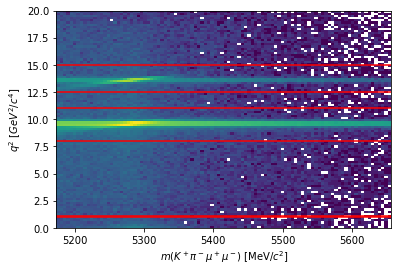

In [34]:
overlay_q2_cuts(total_dataset)

m_inv range [5182.063900339033, 5576.687108537558]
q2_range [0, 20]


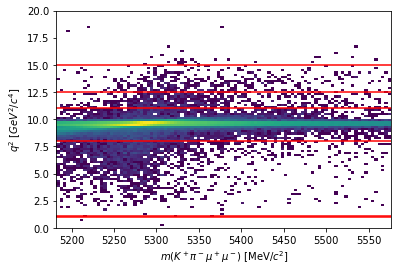

In [35]:
overlay_q2_cuts(jpsi)

m_inv range [5192.285290974594, 5423.804985308397]
q2_range [0, 20]


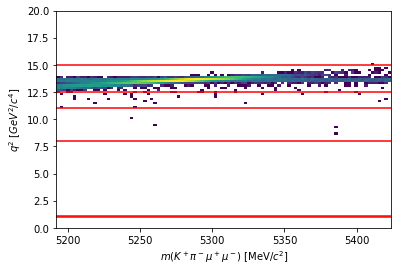

In [36]:
overlay_q2_cuts(psi2S)

In [37]:
benchmark_cut(selection_7)

Total        reduced by 88.74% or 442119 samples 	from 498245 to 56126
Signal       reduced by 36.35% or 92956 samples 	from 255741 to 162785
J/Psi        reduced by 99.62% or 783765 samples 	from 786776 to 3011
Psi(2S)      reduced by 99.96% or 181007 samples 	from 181076 to 69
J/Psi_mu/k   reduced by 54.73% or 1087 samples 	from 1986 to 899
J/Psi_mu/pi  reduced by 44.50% or 344 samples 	from 773 to 429
K0_k/pi      reduced by 36.82% or 49084 samples 	from 133292 to 84208
Phi_mu_mu    reduced by 37.71% or 25764 samples 	from 68318 to 42554
pK_pi/K_k/pi reduced by 25.64% or 371 samples 	from 1447 to 1076
pK_p/pi      reduced by 26.80% or 302 samples 	from 1127 to 825


In [38]:
for cut in cut_q2:
    print('cut q2:', cut)
    selection_7_modified = partial(selection_7, cut_q2=[cut])
    benchmark_cut(selection_7_modified)
    print()

cut q2: [0.98, 1.1]
Total        reduced by 0.07% or 325 samples 	from 498245 to 497920
Signal       reduced by 0.46% or 1185 samples 	from 255741 to 254556
J/Psi        reduced by 0.00% or 2 samples 	from 786776 to 786774
Psi(2S)      reduced by 0.00% or 0 samples 	from 181076 to 181076
J/Psi_mu/k   reduced by 0.05% or 1 samples 	from 1986 to 1985
J/Psi_mu/pi  reduced by 0.00% or 0 samples 	from 773 to 773
K0_k/pi      reduced by 0.45% or 604 samples 	from 133292 to 132688
Phi_mu_mu    reduced by 0.46% or 312 samples 	from 68318 to 68006
pK_pi/K_k/pi reduced by 1.31% or 19 samples 	from 1447 to 1428
pK_p/pi      reduced by 0.80% or 9 samples 	from 1127 to 1118

cut q2: [8.0, 11.0]
Total        reduced by 75.17% or 374528 samples 	from 498245 to 123717
Signal       reduced by 18.22% or 46588 samples 	from 255741 to 209153
J/Psi        reduced by 99.56% or 783338 samples 	from 786776 to 3438
Psi(2S)      reduced by 0.00% or 7 samples 	from 181076 to 181069
J/Psi_mu/k   reduced by 43.40%

### selection 8

$\mathrm{DLL}_{K\pi} = \log(\mathcal{L}_K) - \log(\mathcal{L}_\pi)$

$\mathrm{DLL}_{\mu\pi} = \log(\mathcal{L}_\mu) - \log(\mathcal{L}_\pi)$

In [39]:
# add in DLL columns
def calc_DLL(a, b):
    return np.log(a) - np.log(b)

def add_DLL_KPi(data):
    data['DLL_KPi_K'] = calc_DLL(data['K_MC15TuneV1_ProbNNk'], data['K_MC15TuneV1_ProbNNpi'])
    data['DLL_KPi_Pi'] = calc_DLL(data['Pi_MC15TuneV1_ProbNNk'], data['Pi_MC15TuneV1_ProbNNpi'])

def add_DLL_MuPi(data):
    data['DLL_MuPi_Muplus'] = calc_DLL(data['mu_plus_MC15TuneV1_ProbNNmu'], data['mu_plus_MC15TuneV1_ProbNNpi'])
    data['DLL_MuPi_Muminus'] = calc_DLL(data['mu_minus_MC15TuneV1_ProbNNmu'], data['mu_minus_MC15TuneV1_ProbNNpi'])

for data in all_datasets:
    add_DLL_KPi(data)
    add_DLL_MuPi(data)

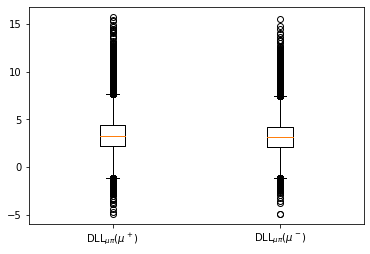

In [40]:
plt.boxplot(signal['DLL_MuPi_Muplus'], labels=[r'$\mathrm{DLL}_{\mu\pi}(\mu^+)$'])
plt.boxplot(signal['DLL_MuPi_Muminus'], positions=[2], labels=[r'$\mathrm{DLL}_{\mu\pi}(\mu^-)$']);

In [41]:
def selection_8(data, DLL_MuPu_thresh=-3, DLL_Kpi_K_thresh=-5,DLL_Kpi_Pi_thresh=25):
    data = data[data['DLL_MuPi_Muplus'] > DLL_MuPu_thresh]
    data = data[data['DLL_MuPi_Muminus'] > DLL_MuPu_thresh]
    data = data[data['DLL_KPi_K'] > DLL_Kpi_K_thresh]
    data = data[data['DLL_KPi_Pi'] < DLL_Kpi_Pi_thresh] 
    return data

In [42]:
benchmark_cut(selection_8)

Total        reduced by 27.17% or 135366 samples 	from 498245 to 362879
Signal       reduced by 0.14% or 351 samples 	from 255741 to 255390
J/Psi        reduced by 25.75% or 202624 samples 	from 786776 to 584152
Psi(2S)      reduced by 0.16% or 296 samples 	from 181076 to 180780
J/Psi_mu/k   reduced by 46.17% or 917 samples 	from 1986 to 1069
J/Psi_mu/pi  reduced by 2.07% or 16 samples 	from 773 to 757
K0_k/pi      reduced by 75.31% or 100387 samples 	from 133292 to 32905
Phi_mu_mu    reduced by 0.10% or 71 samples 	from 68318 to 68247
pK_pi/K_k/pi reduced by 3.04% or 44 samples 	from 1447 to 1403
pK_p/pi      reduced by 0.00% or 0 samples 	from 1127 to 1127


### selection 9

5170 < m(K+piu+u-) < 5700

In [43]:
m_B0 = signal['B0_MM']
np.percentile(m_B0, [0.05, 99.95])

array([5171.39572365, 5482.00899873])

In [44]:
def selection_9(data):
    data = data[data['B0_MM'].between(5170,5700)] # B0
    data = data[data['Kstar_MM'].between(795.9,995.9)] # add k*
    return data

In [45]:
benchmark_cut(selection_9)

Total        reduced by 35.58% or 177289 samples 	from 498245 to 320956
Signal       reduced by 7.34% or 18773 samples 	from 255741 to 236968
J/Psi        reduced by 19.74% or 155283 samples 	from 786776 to 631493
Psi(2S)      reduced by 8.15% or 14764 samples 	from 181076 to 166312
J/Psi_mu/k   reduced by 39.12% or 777 samples 	from 1986 to 1209
J/Psi_mu/pi  reduced by 37.39% or 289 samples 	from 773 to 484
K0_k/pi      reduced by 39.49% or 52637 samples 	from 133292 to 80655
Phi_mu_mu    reduced by 47.31% or 32324 samples 	from 68318 to 35994
pK_pi/K_k/pi reduced by 44.51% or 644 samples 	from 1447 to 803
pK_p/pi      reduced by 50.75% or 572 samples 	from 1127 to 555


### Peaking Backgrouds

In [46]:
def peaking_1(data,low=5170,up=5450):
    # p \pi misidentified
    # p k and k \pi misidentified
    data_ = data[~data['B0_MM'].between(low,up)]
    _data = data[data['B0_MM'].between(low,up)]
    _data = _data[(_data['Pi_MC15TuneV1_ProbNNp'] - _data['Pi_MC15TuneV1_ProbNNpi']) < -0.25]
    _data = _data[(_data['Pi_MC15TuneV1_ProbNNk'] - _data['Pi_MC15TuneV1_ProbNNpi']) < -0.25]
    data = pd.concat([data_,_data])
    return data

<AxesSubplot:>

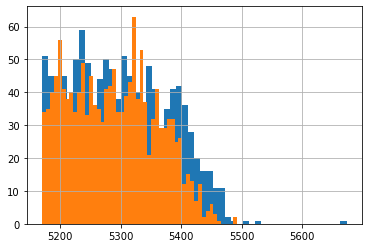

In [47]:
# plot invariant mass to determine mass range
pKmumu_piTop['B0_MM'].hist(bins=50)
pKmumu_piTok_kTop['B0_MM'].hist(bins=50)



<AxesSubplot:>

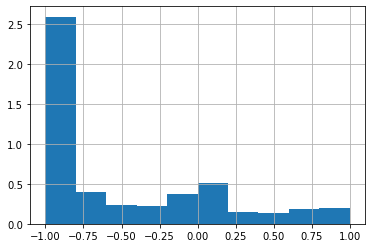

In [48]:
# optimize cuts
plt.figure()
_data = total_dataset[total_dataset['B0_MM'].between(5170,5470)]
#_data['Pi_MC15TuneV1_ProbNNp'].hist()
#_data['Pi_MC15TuneV1_ProbNNpi'].hist()
a = _data['Pi_MC15TuneV1_ProbNNp'] - _data['Pi_MC15TuneV1_ProbNNpi']
a.hist(density=True)

In [49]:
benchmark_cut(peaking_1)

Total        reduced by 30.57% or 152313 samples 	from 498245 to 345932
Signal       reduced by 4.02% or 10280 samples 	from 255741 to 245461
J/Psi        reduced by 33.15% or 260836 samples 	from 786776 to 525940
Psi(2S)      reduced by 3.47% or 6284 samples 	from 181076 to 174792
J/Psi_mu/k   reduced by 4.78% or 95 samples 	from 1986 to 1891
J/Psi_mu/pi  reduced by 75.55% or 584 samples 	from 773 to 189
K0_k/pi      reduced by 89.19% or 118888 samples 	from 133292 to 14404
Phi_mu_mu    reduced by 96.32% or 65807 samples 	from 68318 to 2511
pK_pi/K_k/pi reduced by 94.68% or 1370 samples 	from 1447 to 77
pK_p/pi      reduced by 94.85% or 1069 samples 	from 1127 to 58


In [50]:
def peaking_2(data):
    # Jpsi 
    # mu k
    data_ = data[~data['J_psi_MM'].between(1000,3700)]
    _data = data[data['J_psi_MM'].between(1000,3700)]
    _data = _data[_data['K_MC15TuneV1_ProbNNmu'] < 0.6]
    _data = _data[_data['K_MC15TuneV1_ProbNNk'] > 0.2]
    data = pd.concat([data_,_data])
    # mu pi
    data_ = data[~data['J_psi_MM'].between(1000,3500)]
    _data = data[data['J_psi_MM'].between(1000,3500)]
    _data = _data[_data['Pi_MC15TuneV1_ProbNNmu'] < 0.6]
    _data = _data[_data['Pi_MC15TuneV1_ProbNNpi'] > 0.2]
    data = pd.concat([data_,_data])
    return data


<AxesSubplot:>

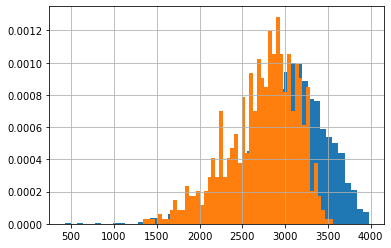

In [51]:
# plot invariant mass to determine mass range
#jpsi_mu_k_swap_cut = cut_data(jpsi_mu_k_swap,cut_q2)
jpsi_mu_k_swap['J_psi_MM'].hist(bins=50,density=True) # 1000,3700
#jpsi_mu_pi_swap_cut = cut_data(jpsi_mu_pi_swap,cut_q2)
jpsi_mu_pi_swap['J_psi_MM'].hist(bins=50,density=True) # 1000,3500


<AxesSubplot:>

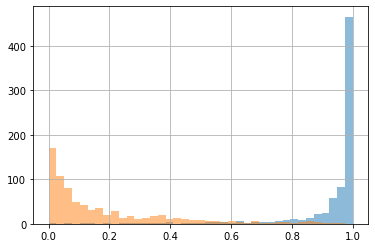

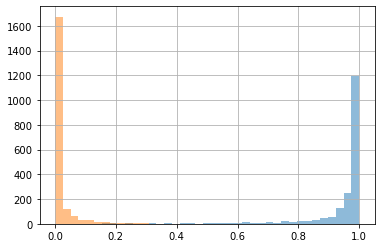

In [52]:
#total_dataset['Pi_MC15TuneV1_ProbNNmu'].hist(bins=np.linspace(0,1,40))
plt.figure()
jpsi_mu_pi_swap['Pi_MC15TuneV1_ProbNNmu'].hist(bins=np.linspace(0,1,40),alpha=0.5)
jpsi_mu_pi_swap['Pi_MC15TuneV1_ProbNNpi'].hist(bins=np.linspace(0,1,40),alpha=0.5)

plt.figure()
jpsi_mu_k_swap['K_MC15TuneV1_ProbNNmu'].hist(bins=np.linspace(0,1,40),alpha=0.5)
jpsi_mu_k_swap['K_MC15TuneV1_ProbNNk'].hist(bins=np.linspace(0,1,40),alpha=0.5)


In [53]:
benchmark_cut(peaking_2)

Total        reduced by 54.99% or 273995 samples 	from 498245 to 224250
Signal       reduced by 4.30% or 10996 samples 	from 255741 to 244745
J/Psi        reduced by 40.64% or 319723 samples 	from 786776 to 467053
Psi(2S)      reduced by 5.16% or 9338 samples 	from 181076 to 171738
J/Psi_mu/k   reduced by 94.91% or 1885 samples 	from 1986 to 101
J/Psi_mu/pi  reduced by 94.44% or 730 samples 	from 773 to 43
K0_k/pi      reduced by 60.76% or 80991 samples 	from 133292 to 52301
Phi_mu_mu    reduced by 52.64% or 35962 samples 	from 68318 to 32356
pK_pi/K_k/pi reduced by 80.30% or 1162 samples 	from 1447 to 285
pK_p/pi      reduced by 71.34% or 804 samples 	from 1127 to 323


In [54]:
def peaking_3(data):
    # B0 -> phi(1020) mu mu; phi -> K K 
    # k pi
    data_res = data[~data['B0_MM'].between(5170,5350)] # B0 mass
    data_touse = data[data['B0_MM'].between(5170,5350)]
    
    data_ = data_touse[~data_touse['Kstar_MM'].between(744,830)]
    _data = data_touse[data_touse['Kstar_MM'].between(744,830)]
   
    _data = _data[(_data['Pi_MC15TuneV1_ProbNNpi'] - _data['Pi_MC15TuneV1_ProbNNk']) > 0.75]
    
    data_touse = pd.concat([_data,data_])
    data = pd.concat([data_touse,data_res])
    return data

<AxesSubplot:>

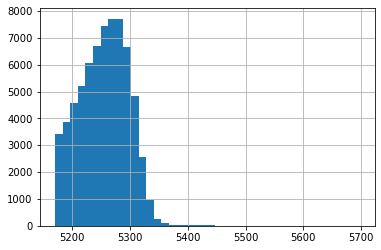

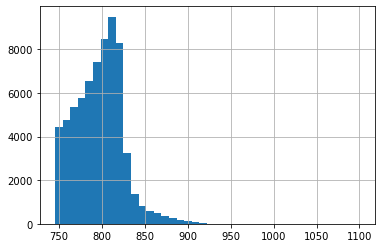

In [55]:
phimumu['B0_MM'].hist(bins=40) # 5170,5350
plt.figure()
phimumu['Kstar_MM'].hist(bins=40)




<AxesSubplot:>

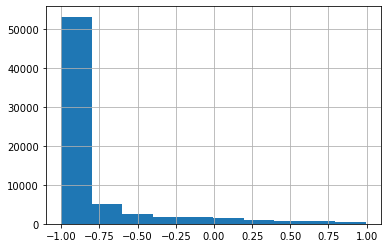

In [56]:
a = phimumu['Pi_MC15TuneV1_ProbNNpi'] - phimumu['Pi_MC15TuneV1_ProbNNk']
a.hist()

In [57]:
benchmark_cut(peaking_3)

Total        reduced by 6.33% or 31527 samples 	from 498245 to 466718
Signal       reduced by 0.56% or 1443 samples 	from 255741 to 254298
J/Psi        reduced by 7.21% or 56719 samples 	from 786776 to 730057
Psi(2S)      reduced by 0.68% or 1232 samples 	from 181076 to 179844
J/Psi_mu/k   reduced by 3.17% or 63 samples 	from 1986 to 1923
J/Psi_mu/pi  reduced by 15.39% or 119 samples 	from 773 to 654
K0_k/pi      reduced by 18.42% or 24548 samples 	from 133292 to 108744
Phi_mu_mu    reduced by 90.98% or 62155 samples 	from 68318 to 6163
pK_pi/K_k/pi reduced by 14.17% or 205 samples 	from 1447 to 1242
pK_p/pi      reduced by 12.33% or 139 samples 	from 1127 to 988


In [58]:
def peaking_4(data):
    # only k pi swap
    data = data[(data['Pi_MC15TuneV1_ProbNNpi'] - data['Pi_MC15TuneV1_ProbNNk']) > -0.7]
    data = data[(data['K_MC15TuneV1_ProbNNk'] - data['K_MC15TuneV1_ProbNNpi']) > -0.7]
    return data

In [59]:
benchmark_cut(peaking_4)

Total        reduced by 44.27% or 220582 samples 	from 498245 to 277663
Signal       reduced by 2.60% or 6644 samples 	from 255741 to 249097
J/Psi        reduced by 34.58% or 272031 samples 	from 786776 to 514745
Psi(2S)      reduced by 3.10% or 5617 samples 	from 181076 to 175459
J/Psi_mu/k   reduced by 4.08% or 81 samples 	from 1986 to 1905
J/Psi_mu/pi  reduced by 0.91% or 7 samples 	from 773 to 766
K0_k/pi      reduced by 95.57% or 127387 samples 	from 133292 to 5905
Phi_mu_mu    reduced by 83.05% or 56738 samples 	from 68318 to 11580
pK_pi/K_k/pi reduced by 78.30% or 1133 samples 	from 1447 to 314
pK_p/pi      reduced by 12.87% or 145 samples 	from 1127 to 982


In [60]:
# tot_dataset = selection_7(total_dataset)
# data = tot_dataset[tot_dataset['B0_MM'].between(5170,5250)]
# signal_ = selection_7(signal)
# sig = signal_[signal_['B0_MM'].between(5170,5250)]
# set = selected[selected['B0_MM'].between(5170,5250)]

# sig['J_psi_MM'].hist(bins=50,density=True,alpha=0.5)
# data['J_psi_MM'].hist(bins=50,density=True,alpha=0.5)
# set['J_psi_MM'].hist(bins=50,density=True,alpha=0.5)

            

### total selection

combine all selections, keep all, even ones that don't seem to do anything 

In [61]:
def selection_all(data):
    #selections = [selection_1_final] + [eval(f'selection_{i}') for i in range(2, 10)]
    selections = [eval(f'selection_{i}') for i in range(2, 10)] + [eval(f'peaking_{i}') for i in range(1, 5)]
    for selection in selections:
        data = selection(data)
    return data

In [62]:
benchmark_cut(selection_all)

Total        reduced by 98.94% or 492977 samples 	from 498245 to 5268
Signal       reduced by 48.02% or 122810 samples 	from 255741 to 132931
J/Psi        reduced by 99.99% or 786712 samples 	from 786776 to 64
Psi(2S)      reduced by 99.98% or 181045 samples 	from 181076 to 31
J/Psi_mu/k   reduced by 99.75% or 1981 samples 	from 1986 to 5
J/Psi_mu/pi  reduced by 98.71% or 763 samples 	from 773 to 10
K0_k/pi      reduced by 99.73% or 132926 samples 	from 133292 to 366
Phi_mu_mu    reduced by 99.65% or 68080 samples 	from 68318 to 238
pK_pi/K_k/pi reduced by 99.10% or 1434 samples 	from 1447 to 13
pK_p/pi      reduced by 99.02% or 1116 samples 	from 1127 to 11


In [63]:
selected = selection_all(total_dataset)

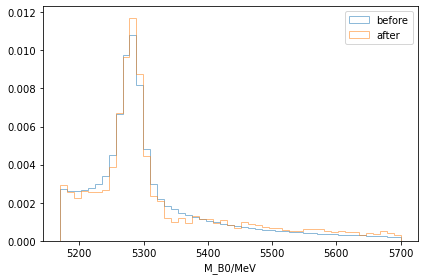

In [64]:
fig = plt.figure(figsize=[6,4],tight_layout=True)
#plt.hist(dataset_cut["B0_MM"], bins = np.linspace(5170,5700,50), density=True, histtype='step', alpha = 0.5,label='before')
plt.hist(total_dataset["B0_MM"], bins = np.linspace(5170,5700,50), density=True, histtype='step', alpha = 0.5,label='before')
plt.hist(selected["B0_MM"], bins = np.linspace(5170,5700,50), density=True, histtype='step', alpha = 0.5,label='after')
#plt.hist(classified_cut["B0_MM"], bins = np.linspace(5170,5700,50), density=True, alpha = 0.5,label='classified')
plt.xlabel("M_B0/MeV")
#plt.yscale('log')
plt.legend()
#plt.savefig('plots/compare_imvarant_mass_machine.png')
plt.show()

In [65]:
from selection_criteria.functions import bin_data
q2_bins = [[0.1, 0.98],[1.1, 2.5],[2.5, 4.0],[4.0, 6.0],[6.0, 8.0],[15.0, 17.0],[17.0, 19.0],[11.0, 12.5],[1.0, 6.0],[15.0, 17.9]]

binned_data = bin_data(selected,q2_bins)
binned_total = bin_data(total_dataset,q2_bins)

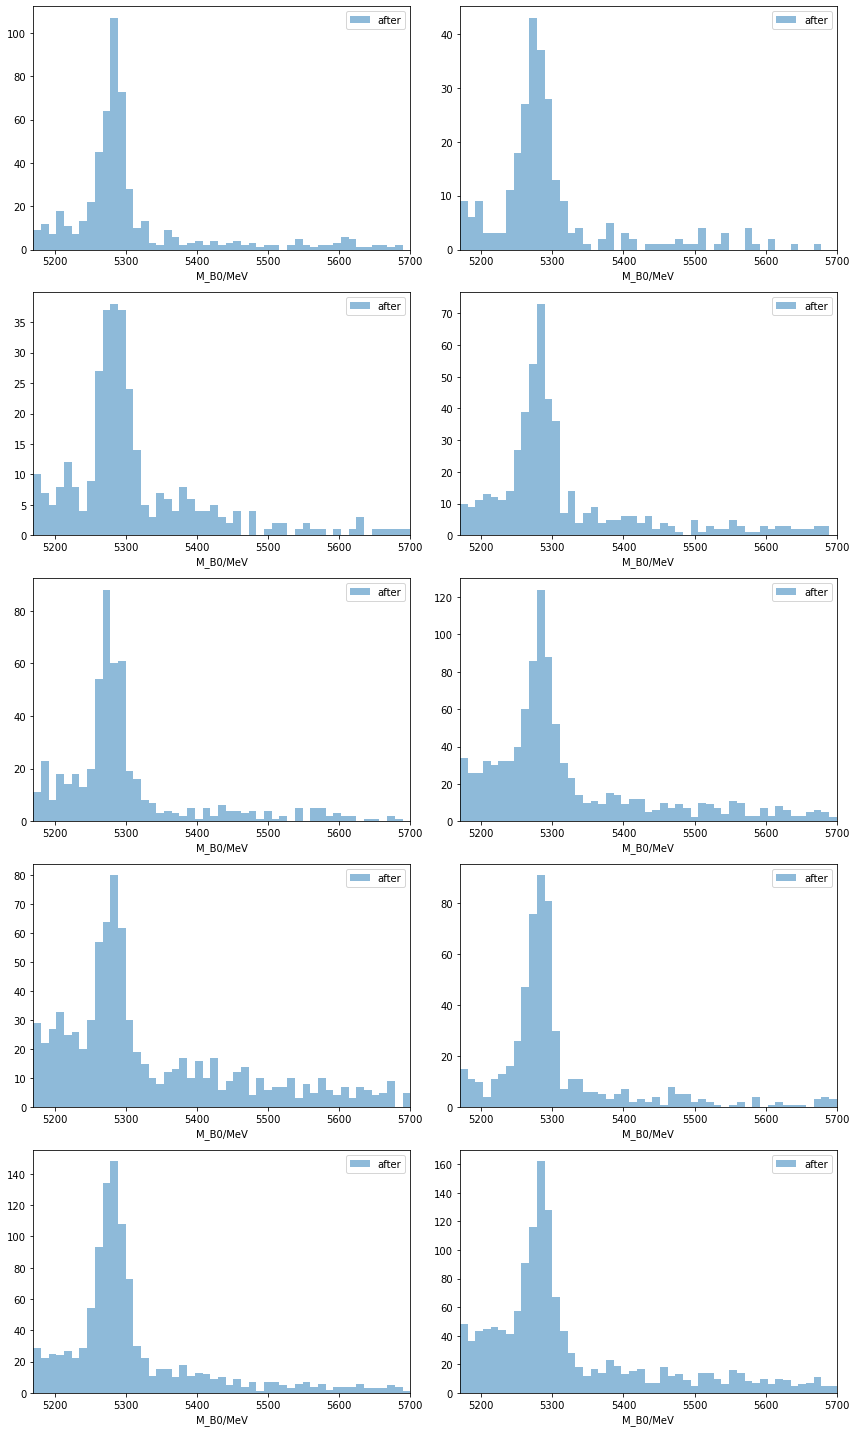

In [66]:
plt.figure(figsize=[6*2,4*5],tight_layout=True)
for i in range(0,10):
    plt.subplot(5,2,i+1)
    #plt.hist(binned_total[i]["B0_MM"], bins = np.linspace(5170,5700,50), density=False, alpha = 0.5,label='before')
    plt.hist(binned_data[i]["B0_MM"], bins = np.linspace(5170,5700,50), density=False, alpha = 0.5,label='after')
    plt.xlim([5170,5700])
    plt.xlabel("M_B0/MeV")
    plt.legend()  
plt.show()

### Fitting Crystal Ball function 

Followed by work from Yuchen Kang

In [67]:
import crystal_ball as cry
from imp import reload
reload(cry)
from scipy.optimize import curve_fit
import scipy as sp

In [68]:
def fit_crystal_ball(data,sigma,alpha,n):
    # get data
    bin_height, bin_edges, patches = plt.hist(data["B0_MM"], bins = np.linspace(5170,5700,41), alpha = 0.5, rwidth=0)
    
    x = np.zeros(len(bin_height))
    for i in range (0,len(bin_edges)-1):
        x[i] = (bin_edges[i]+bin_edges[i+1])/2
    yerr = np.sqrt(bin_height)

    plt.errorbar(x,bin_height,yerr=yerr,fmt='.',c='black')

    
    # get p0
    A = np.max(bin_height)
    mean = x[bin_height.argmax()]
    #sigma = 15
    #alpha = 1.5
    #n=75
    coe = bin_height[0]
    tau = np.log(bin_height[0]/(np.mean(bin_height[-15:-1])))*1/590
    
    p0 = [A,mean,sigma,alpha,n,coe,tau]
    #p0 = [A,mean,sigma,coe,tau]
    
    # fitting 
    popt,pcov = curve_fit(cry.crystal_ball, x, bin_height,p0 = p0)
    
    x_plot = np.linspace(5170,5700,500)
    y = cry.crystal_ball(x_plot,*popt)

    plt.plot(x_plot,y)
    plt.xlim([5170,5700])
    plt.xlabel("M_B0/MeV")
    plt.grid()
    
    
    # print('A = %.3f +- %.3f'%(popt[0],pcov[0][0]**0.5))
    # print('mu = %.3f +- %.3f'%(popt[1],pcov[1][1]**0.5))
    # print('sigma = %.3f +- %.3f'%(popt[2],pcov[2][2]**0.5))
    # print('alpha = %.3f +- %.3f'%(popt[3],pcov[3][3]**0.5))
    # print('n = %.3f +- %.3f'%(popt[4],pcov[4][4]**0.5))
    # print('coe = %.3f +- %.3f'%(popt[5],pcov[5][5]**0.5))
    # print('tau = %.4f +- %.4f'%(popt[6],pcov[6][6]**0.5))
    # print('++++++++++++++++')
    return popt,pcov

    


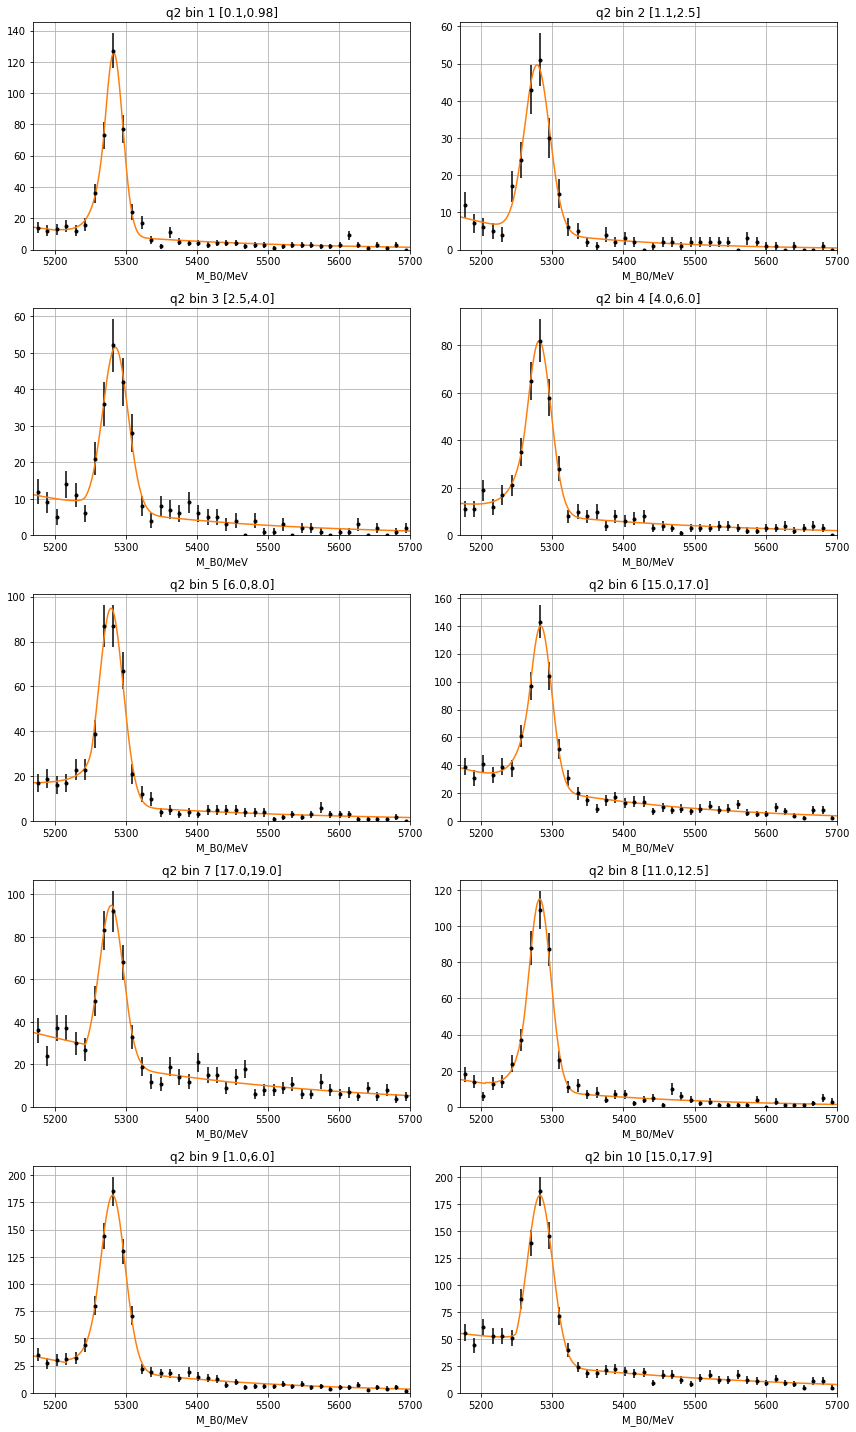

In [69]:
# this cell may print warings un-usedtthe first three lines to display
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    
    Var = [[] for i in range (0,7)]
    Err = [[] for i in range (0,7)]
    
    n = [75,2,80,75,75,50,80,50,75,75]
    alpha = [1.5,15,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5]
    sigma = [15,18,10,15,15,15,10,15,15,15]
    #opt,cov = fit_crystal_ball(binned_data[-4],alpha[-4],n[-4])
    #print(opt[-3])
    #print(opt[-4])
    
    
    plt.figure(figsize=[6*2,4*5],tight_layout=True)
    for i in range(0,10):
        #print(f'q2 bin {i+1} [{q2_bins[i][0]},{q2_bins[i][1]}]')
        plt.subplot(5,2,i+1)
        plt.title(f'q2 bin {i+1} [{q2_bins[i][0]},{q2_bins[i][1]}]')
        opt,cov = fit_crystal_ball(binned_data[i],sigma[i],alpha[i],n[i])
        for j in range(0,7):
            Var[j].append(opt[j])
            Err[j].append(cov[j][j]**0.5) 
    plt.show()
    
    

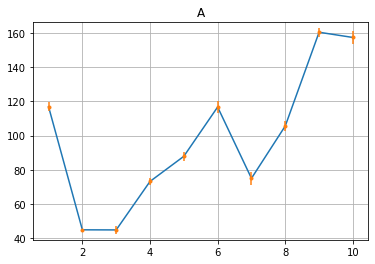

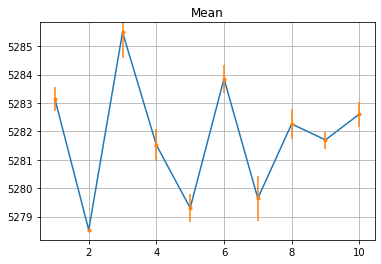

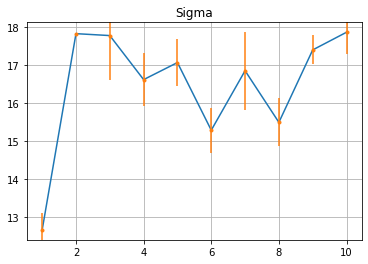

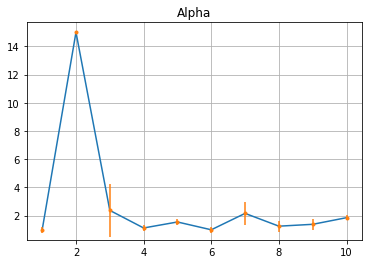

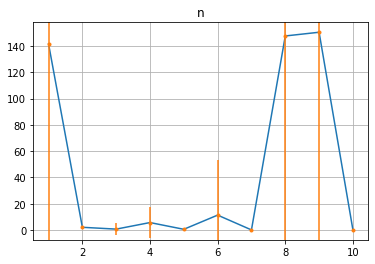

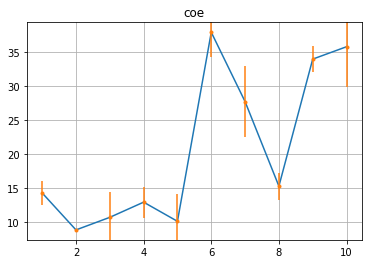

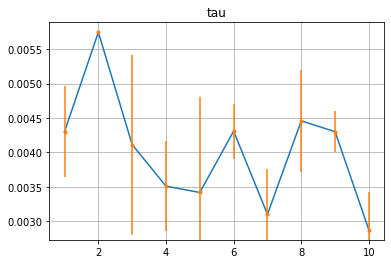

In [70]:
num = [1,2,3,4,5,6,7,8,9,10]
title = ["A","Mean",'Sigma','Alpha','n','coe','tau']
for i in range(len(Var)):
    plt.figure()
    plt.title(title[i])
    plt.plot(num,Var[i])
    plt.errorbar(num,Var[i],yerr=Err[i],fmt='.')
    plt.grid()
    plt.show()

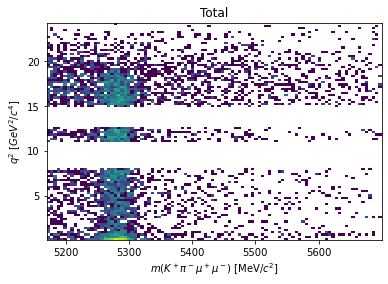

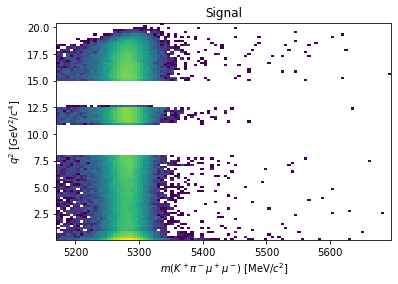

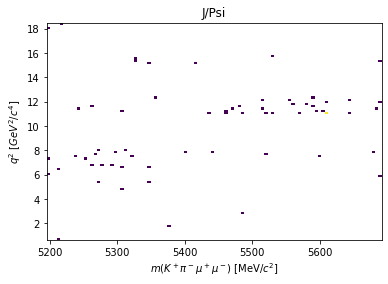

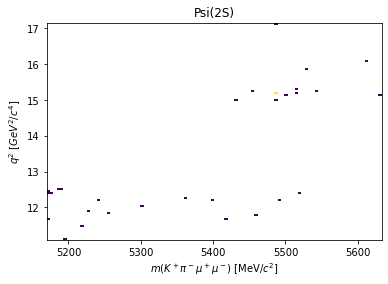

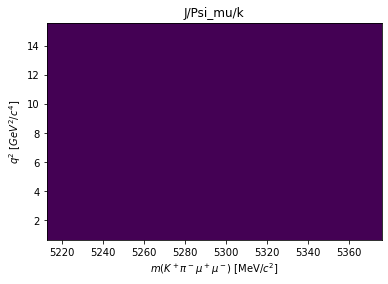

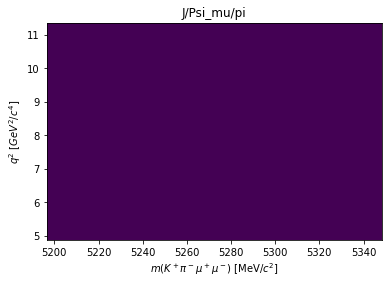

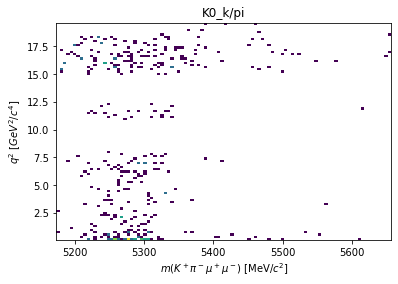

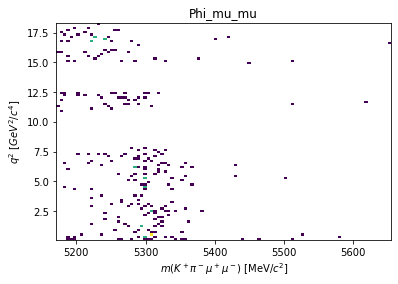

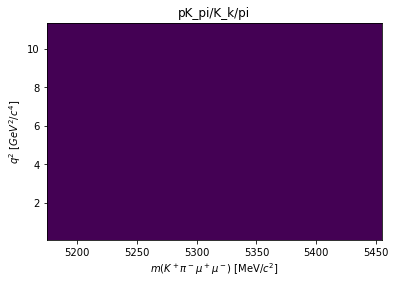

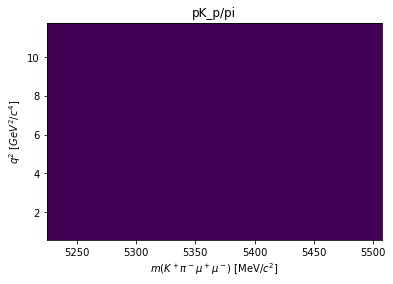

In [71]:
for name, data in zip(all_names, all_datasets):
    plot_q2_m_inv(selection_all(data), set_range=False)
    plt.title(name)
    plt.show()

## decision tree

In [72]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import plot_tree

In [73]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

### construct combined dataset

1. add labels to each dataset
2. concatenate datasets 
3. split into train + test 

In [74]:
# total momentum + transverse
def add_B0_momentums(data):
    particles = ['mu_plus', 'mu_minus', 'K', 'Pi']
    data['B0_PT'] = sum(data[s + '_PT'] for s in particles)
    data['B0_P'] = sum(data[s + '_P'] for s in particles)

for data in all_datasets:
    add_B0_momentums(data)

In [75]:
train_datasets, train_names = all_datasets[1:], all_names[1:] # exclude total_dataset

for i in [1, 2]:
    print('Applied q2 cut on', train_names[i])
    train_datasets[i] = selection_7(train_datasets[i])

for name, data in zip(train_names, train_datasets):
    decay_type = pd.Categorical([name]*len(data), categories=train_names, ordered=True)
    data['decay_type'] = decay_type

Applied q2 cut on J/Psi
Applied q2 cut on Psi(2S)


In [76]:
# columns to keep 
column_labels = ['decay_type'] # training labels 

columns_keep_train = ['DLL_KPi_K', 'DLL_KPi_Pi', 'DLL_MuPi_Muplus', 'DLL_MuPi_Muminus'] # DLL vars
columns_keep_train += ['B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV'] # B0 chi2 + DIRA
columns_keep_train += ['B0_PT', 'B0_P'] # B0 momentums
columns_keep = column_labels + columns_keep_train

In [77]:
# columns_remove = ['decay_type', 'q2', 'phi', 'costhetal', 'costhetak']
# columns_remove += ['B0_MM', 'B0_ID', 'polarity', 'year']
# columns_remove += [s + '_ENDVERTEX_NDOF' for s in ['B0', 'Kstar', 'J_psi']]
# columns_remove += ['B0_OWNPV_' + s for s in ['X', 'Y', 'Z']]
# columns_keep_train = list(set(signal.columns) - set(columns_remove))
# columns_keep = column_labels + columns_keep_train
# sorted(columns_keep_train)

In [78]:
train_datasets_reduced = (data[columns_keep] for data in train_datasets)
datasets_concat = pd.concat(train_datasets_reduced, ignore_index=True)

datasets_concat.shape

(465764, 9)

In [79]:
# del signal
# del jpsi
# del psi2S
# del jpsi_mu_k_swap
# del jpsi_mu_pi_swap
# del k_pi_swap
# del phimumu
# del pKmumu_piTok_kTop
# del pKmumu_piTop
# del all_datasets

### generate test + train dataset

In [80]:
rng = np.random.RandomState(42) # need to rerun after each training for reproducibility 

In [81]:
X, y = datasets_concat[columns_keep_train], datasets_concat[column_labels[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

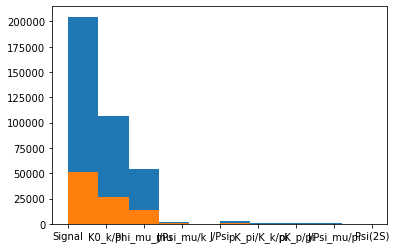

In [82]:
# verify that distribution of labels the same 
plt.hist(y_train)
plt.hist(y_test);

### do fitting

In [118]:
load_model_from_save = True # whether to regenerate classifier or load pre-trained DT

In [84]:
# hyperparameter search, takes a few minutes to run 
# commented out, optimised parameters below 

# clf = HistGradientBoostingClassifier(random_state=rng)

# params_distr = {
#     'learning_rate': sps.uniform(loc=0.08, scale=0.4),
#     'max_iter': [50, 100, 150, 200, 250],
#     'l2_regularization': sps.uniform(loc=0, scale=0.2)
# }
# search = HalvingRandomSearchCV(clf, params_distr, factor=3, max_resources=20000,
#                                random_state=rng, verbose=2, n_jobs=2).fit(X_train, y_train)

# print(search.best_params_)

In [85]:
# search_best_params = {'l2_regularization': 0.01, 'learning_rate': 0.15, 'max_iter': 100}
# search_best_params = {'l2_regularization': 0.002, 'learning_rate': 0.12, 'max_iter': 120}
search_best_params = {'l2_regularization': 0.18416714021091232, 'learning_rate': 0.1450747407932629, 'max_iter': 250} # best so far 

clf = HistGradientBoostingClassifier(**search_best_params, random_state=rng)

In [86]:
# cross-validate with KFolds

if not load_model_from_save:
    skf = StratifiedKFold(n_splits=10)

    all_scores_cross_val = []
    cm_predict_cross_val = np.zeros((10, len(train_names), len(train_names)), dtype=int)
    for i, (idx_train, idx_test) in enumerate(skf.split(X_train, y_train)): 
        #if i > 1:
        #    break

        clf.fit(X_train.iloc[idx_train], y_train.iloc[idx_train])
        score = clf.score(X_train.iloc[idx_test], y_train.iloc[idx_test])
        all_scores_cross_val.append(score)
        print(f'{i}th fold: {score*100:.3f}%')

        cm_predict = confusion_matrix(y_test, clf.predict(X_test), labels=train_names)
        cm_predict_cross_val[i,:] = cm_predict
        
        with open(f'./final_data_processed/GBDT_trained_{i}.pkl', 'wb') as f:
            pickle.dump(clf, f)

    print()
    print(f'Avg score: {np.mean(all_scores_cross_val)*100:.3f}%')

0th fold: 94.646%
1th fold: 94.654%
2th fold: 94.563%
3th fold: 94.469%
4th fold: 94.442%
5th fold: 94.587%
6th fold: 94.632%
7th fold: 94.410%
8th fold: 94.332%
9th fold: 94.576%

Avg score: 94.531%


In [87]:
if not load_model_from_save:
    clf.fit(X_train, y_train)
    with open('./final_data_processed/GBDT_trained.pkl', 'wb') as f:
        pickle.dump(clf, f)
    print(f'Final evaluation: {clf.score(X_test, y_test)*100:.3f}% accuracy')

Final evaluation: 94.542% accuracy


In [88]:
if load_model_from_save:
    with open('./final_data_processed/GBDT_trained.pkl', 'rb') as f:
        clf = pickle.load(f)

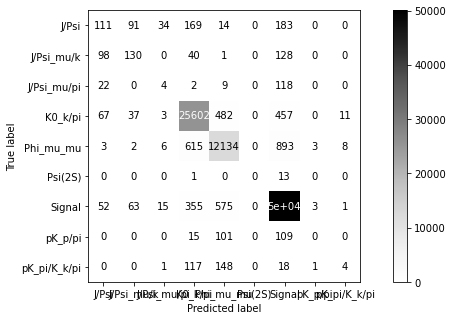

In [89]:
fig, ax = plt.subplots(figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Greys', ax=ax)

In [90]:
cm_predict = confusion_matrix(y_test, clf.predict(X_test), labels=train_names)
n_labels = cm_predict.shape[0]
for i in range(n_labels):
    n_correct = cm_predict[i,i]
    n_wrong = np.sum(cm_predict[i,np.arange(n_labels) != i])
    f_correct = n_correct / (n_correct + n_wrong)
    n_wrong_signal = cm_predict[i,0]
    name_space = "".join([" "]*(12-len(train_names[i])))
    print(f'{train_names[i]}:{name_space} {f_correct*100:.3f}% correct, {n_wrong}/{n_correct + n_wrong} wrong; {n_wrong_signal} wrongly labeled as signal')

Signal:       97.920% correct, 1064/51148 wrong; 50084 wrongly labeled as signal
J/Psi:        18.439% correct, 491/602 wrong; 183 wrongly labeled as signal
Psi(2S):      0.000% correct, 14/14 wrong; 13 wrongly labeled as signal
J/Psi_mu/k:   32.746% correct, 267/397 wrong; 128 wrongly labeled as signal
J/Psi_mu/pi:  2.581% correct, 151/155 wrong; 118 wrongly labeled as signal
K0_k/pi:      96.035% correct, 1057/26659 wrong; 457 wrongly labeled as signal
Phi_mu_mu:    88.803% correct, 1530/13664 wrong; 893 wrongly labeled as signal
pK_pi/K_k/pi: 1.384% correct, 285/289 wrong; 18 wrongly labeled as signal
pK_p/pi:      0.000% correct, 225/225 wrong; 109 wrongly labeled as signal


### create selection function

In [91]:
def selection_dt(data):
    data_ = data[columns_keep_train]
    if len(data_) == 0:
        return data
    y = clf.predict(data_)
    return data[y == 'Signal']

In [92]:
benchmark_cut(selection_dt)

Total        reduced by 43.78% or 218145 samples 	from 498245 to 280100
Signal       reduced by 1.87% or 4789 samples 	from 255741 to 250952
J/Psi        reduced by 35.68% or 280734 samples 	from 786776 to 506042
Psi(2S)      reduced by 1.97% or 3576 samples 	from 181076 to 177500
J/Psi_mu/k   reduced by 71.65% or 1423 samples 	from 1986 to 563
J/Psi_mu/pi  reduced by 33.64% or 260 samples 	from 773 to 513
K0_k/pi      reduced by 98.29% or 131017 samples 	from 133292 to 2275
Phi_mu_mu    reduced by 94.08% or 64275 samples 	from 68318 to 4043
pK_pi/K_k/pi reduced by 93.02% or 1346 samples 	from 1447 to 101
pK_p/pi      reduced by 56.70% or 639 samples 	from 1127 to 488


## combined: hard cuts + decision tree

In [93]:
def selection_all_dt(data):
    data = selection_all(data)
    data = selection_dt(data)
    return data

In [94]:
print('After hard cuts')
benchmark_cut(selection_all)

After hard cuts
Total        reduced by 98.94% or 492977 samples 	from 498245 to 5268
Signal       reduced by 48.02% or 122810 samples 	from 255741 to 132931
J/Psi        reduced by 99.99% or 786712 samples 	from 786776 to 64
Psi(2S)      reduced by 99.98% or 181045 samples 	from 181076 to 31
J/Psi_mu/k   reduced by 99.75% or 1981 samples 	from 1986 to 5
J/Psi_mu/pi  reduced by 98.71% or 763 samples 	from 773 to 10
K0_k/pi      reduced by 99.73% or 132926 samples 	from 133292 to 366
Phi_mu_mu    reduced by 99.65% or 68080 samples 	from 68318 to 238
pK_pi/K_k/pi reduced by 99.10% or 1434 samples 	from 1447 to 13
pK_p/pi      reduced by 99.02% or 1116 samples 	from 1127 to 11


In [95]:
print('After hard cuts + decision tree')
benchmark_cut(selection_all_dt)

After hard cuts + decision tree
Total        reduced by 99.00% or 493272 samples 	from 498245 to 4973
Signal       reduced by 48.08% or 122963 samples 	from 255741 to 132778
J/Psi        reduced by 99.99% or 786720 samples 	from 786776 to 56
Psi(2S)      reduced by 100.00% or 181067 samples 	from 181076 to 9
J/Psi_mu/k   reduced by 99.80% or 1982 samples 	from 1986 to 4
J/Psi_mu/pi  reduced by 98.97% or 765 samples 	from 773 to 8
K0_k/pi      reduced by 99.78% or 133001 samples 	from 133292 to 291
Phi_mu_mu    reduced by 99.66% or 68087 samples 	from 68318 to 231
pK_pi/K_k/pi reduced by 99.17% or 1435 samples 	from 1447 to 12
pK_p/pi      reduced by 99.11% or 1117 samples 	from 1127 to 10


In [96]:
total_dataset_all = selection_all(total_dataset)
total_dataset_all_dt = selection_all_dt(total_dataset)

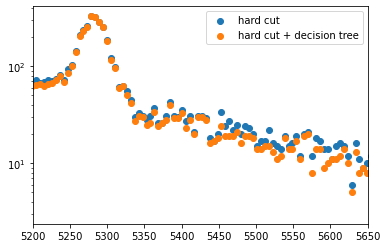

In [97]:
# visualise effect of cuts on data 

# hist_point(total_dataset['B0_MM'], range=(5170, 5700), bins=100, label='unprocessed')
hist_point(total_dataset_all['B0_MM'], range=(5170, 5700), bins=100, label='hard cut')
hist_point(total_dataset_all_dt['B0_MM'], range=(5170, 5700), bins=100, label='hard cut + decision tree')
plt.xlim(5200, 5650)
plt.yscale('log')
plt.legend()

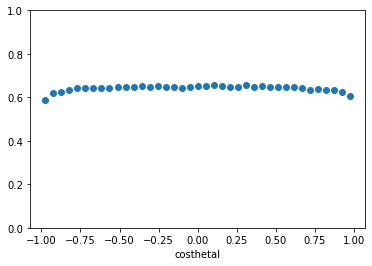

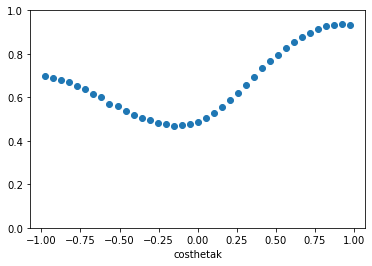

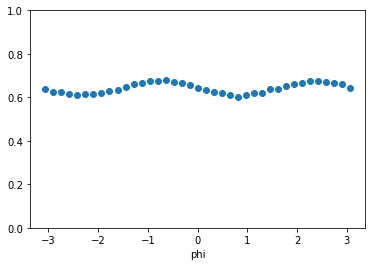

In [98]:
jpsi_dt = selection_dt(jpsi)

for cl in ['costhetal', 'costhetak', 'phi']:
    if cl == 'phi':
        bins = np.linspace(-np.pi, np.pi, 40)
    else:
        bins = np.linspace(-1, 1, 40)
    
    h_jpsi, _ = np.histogram(jpsi[cl], bins=bins)
    h_jpsi_dt, _ = np.histogram(jpsi_dt[cl], bins=bins)

    bin_centres = (bins[:-1] + bins[1:]) / 2
    plt.scatter(bin_centres, h_jpsi_dt / h_jpsi)
    plt.ylim(0, 1)
    plt.xlabel(cl)
    plt.show()

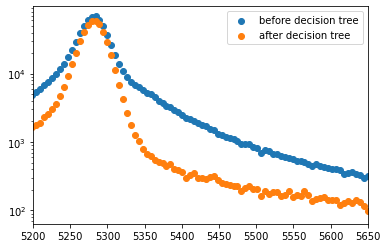

In [99]:
hist_point(jpsi['B0_MM'], range=(5170, 5700), bins=100, label='before decision tree')
hist_point(jpsi_dt['B0_MM'], range=(5170, 5700), bins=100, label='after decision tree')
plt.xlim(5200, 5650)
plt.yscale('log')
plt.legend()

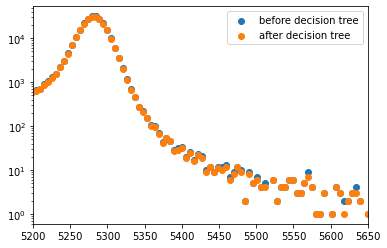

In [100]:
signal_dt = selection_dt(signal)

hist_point(signal['B0_MM'], range=(5170, 5700), bins=100, label='before decision tree')
hist_point(signal_dt['B0_MM'], range=(5170, 5700), bins=100, label='after decision tree')
plt.xlim(5200, 5650)
plt.yscale('log')
plt.legend()

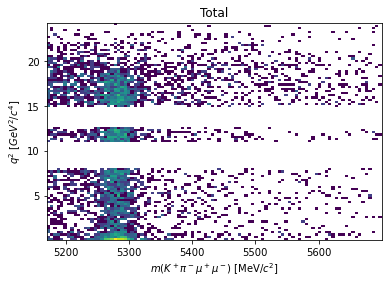

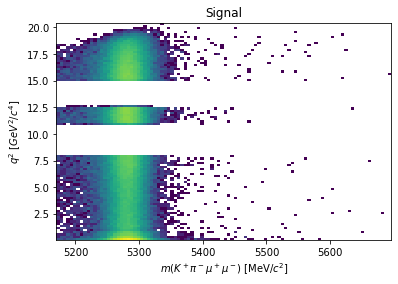

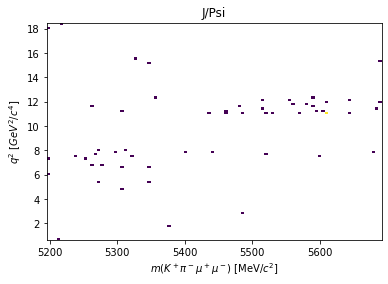

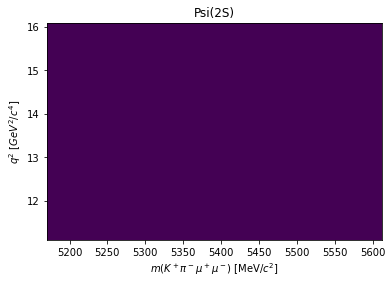

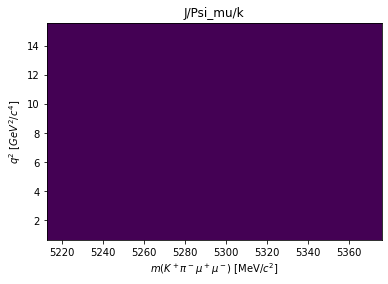

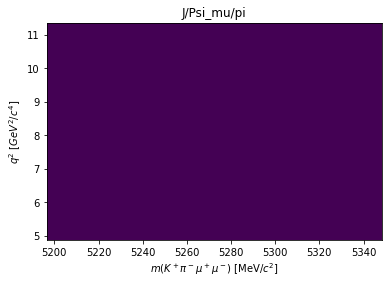

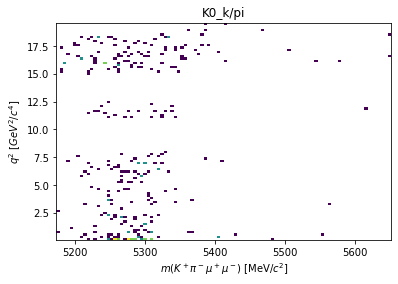

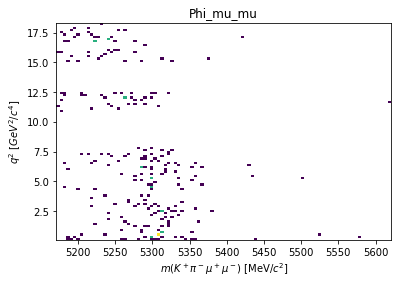

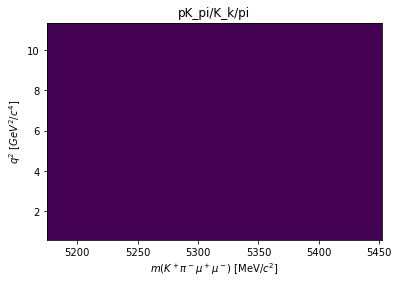

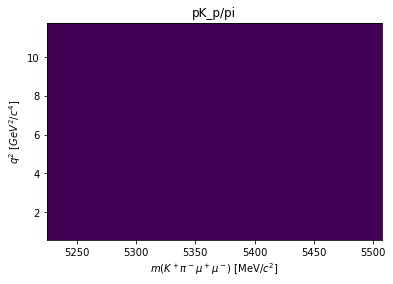

In [101]:
for name, data in zip(all_names, all_datasets):
    plot_q2_m_inv(selection_all_dt(data), set_range=False)
    plt.title(name)
    plt.show()

## estimate composition of dataset

In [102]:
def calc_percentage_cut(data, selection):
    N_before = len(data)
    data = selection(data)
    N_after = len(data)
    return (N_before - N_after) / N_before

In [103]:
def selection_7_JPsi(data):
    cut = cut_q2[1]
    return selection_7(data, cut_q2=[cut])

def selection_7_Psi2S(data):
    cut = cut_q2[2]
    return selection_7(data, cut_q2=[cut])

In [104]:
f_JPsi = calc_percentage_cut(total_dataset, selection_7_JPsi)
f_Psi2S = calc_percentage_cut(total_dataset, selection_7_Psi2S)
print(f'J/Psi fraction: {f_JPsi*100:.3f}%')
print(f'Psi(2S) fraction: {f_Psi2S*100:.3f}%')

J/Psi fraction: 75.169%
Psi(2S) fraction: 13.501%


J/Psi:        1.124%
J/Psi_mu/k:   0.545%
J/Psi_mu/pi:  0.043%
K0_k/pi:      3.933%
Phi_mu_mu:    0.832%
Psi(2S):      0.005%
Signal:       4.763%
pK_p/pi:      0.010%
pK_pi/K_k/pi: 0.011%


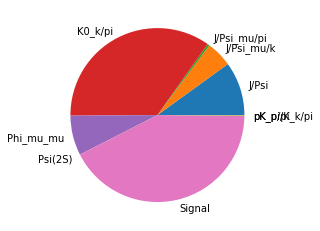

In [105]:
f_JPsi_Psi2S = calc_percentage_cut(total_dataset, selection_7)
f_rest = 1 - f_JPsi_Psi2S

total_dataset_labels = clf.predict(selection_7(total_dataset)[columns_keep_train])
decay_names, N_classified = np.unique(total_dataset_labels, return_counts=True)
plt.pie(N_classified, labels=decay_names)

N_classified_total = np.sum(N_classified)
f_all = {}
for name, N in zip(decay_names, N_classified):
    name_space = "".join([" "]*(12-len(name)))
    f = N / N_classified_total * f_rest
    f_all[name] = f
    print(f'{name}:{name_space} {f * 100:.3f}%')

In [106]:
f_all['J/Psi'] = f_JPsi
f_all['Psi(2S)'] = f_Psi2S

In [107]:
f_all

{'J/Psi': 0.7516944475107628,
 'J/Psi_mu/k': 0.005445112344328595,
 'J/Psi_mu/pi': 0.00043151461630322447,
 'K0_k/pi': 0.03932603438067619,
 'Phi_mu_mu': 0.008317193348653778,
 'Psi(2S)': 0.13500587060582644,
 'Signal': 0.04762917841624102,
 'pK_p/pi': 0.00010235928107657884,
 'pK_pi/K_k/pi': 0.00010637337053056232}

In [108]:
print('frac_total_dataset (from DT) x frac_misclassify = frac_err_whole_dataset')
print()
N_after_selection_all_dt = len(total_dataset_all_dt)
for name, data in zip(all_names[1:], all_datasets[1:]):
    f_misclassified = 1 - calc_percentage_cut(data, selection_all_dt)
    f_err = f_all[name] * f_misclassified
    name_space = "".join([" "]*(12-len(name)))
    print(f'{name}:{name_space} {f_all[name]*100:.2f}% x {f_misclassified*100:.2f}% = {f_err*100:.4f}%, abs {f_err*N_after_selection_all_dt:.4f}')

frac_total_dataset (from DT) x frac_misclassify = frac_err_whole_dataset

Signal:       4.76% x 51.92% = 2.4729%, abs 122.9751
J/Psi:        75.17% x 0.01% = 0.0054%, abs 0.2661
Psi(2S):      13.50% x 0.00% = 0.0007%, abs 0.0334
J/Psi_mu/k:   0.54% x 0.20% = 0.0011%, abs 0.0545
J/Psi_mu/pi:  0.04% x 1.03% = 0.0004%, abs 0.0222
K0_k/pi:      3.93% x 0.22% = 0.0086%, abs 0.4270
Phi_mu_mu:    0.83% x 0.34% = 0.0028%, abs 0.1399
pK_pi/K_k/pi: 0.01% x 0.83% = 0.0001%, abs 0.0044
pK_p/pi:      0.01% x 0.89% = 0.0001%, abs 0.0045


In [109]:
print('frac_total_dataset (from simulation) x frac_misclassify = frac_err_whole_dataset')
print()
N_after_selection_all_dt = len(total_dataset_all_dt)
N_total = sum(len(data) for data in all_datasets[1:])
for name, data in zip(all_names[1:], all_datasets[1:]):
    f_misclassified = 1 - calc_percentage_cut(data, selection_all_dt)
    f_err = len(data) / N_total * f_misclassified
    name_space = "".join([" "]*(12-len(name)))
    print(f'{name}:{name_space} {len(data) / N_total*100:.2f}% x {f_misclassified*100:.2f}% = {f_err*100:.4f}%, abs {f_err*N_after_selection_all_dt:.4f}')

frac_total_dataset (from simulation) x frac_misclassify = frac_err_whole_dataset

Signal:       17.88% x 51.92% = 9.2817%, abs 461.5787
J/Psi:        55.00% x 0.01% = 0.0039%, abs 0.1947
Psi(2S):      12.66% x 0.00% = 0.0006%, abs 0.0313
J/Psi_mu/k:   0.14% x 0.20% = 0.0003%, abs 0.0139
J/Psi_mu/pi:  0.05% x 1.03% = 0.0006%, abs 0.0278
K0_k/pi:      9.32% x 0.22% = 0.0203%, abs 1.0116
Phi_mu_mu:    4.78% x 0.34% = 0.0161%, abs 0.8030
pK_pi/K_k/pi: 0.10% x 0.83% = 0.0008%, abs 0.0417
pK_p/pi:      0.08% x 0.89% = 0.0007%, abs 0.0348


## estimate variance on misclassification

In [110]:
clf_cross_val_all = []
for i in range(10):
    with open(f'./final_data_processed/GBDT_trained_{i}.pkl', 'rb') as f:
        clf = pickle.load(f)
        clf_cross_val_all.append(clf)

In [111]:
f_JPsi_Psi2S = calc_percentage_cut(total_dataset, selection_7)


all_f_all = []
for clf_cross_val in clf_cross_val_all:
    total_dataset_labels = clf_cross_val.predict(selection_7(total_dataset)[columns_keep_train])
    decay_names, N_classified = np.unique(total_dataset_labels, return_counts=True)
#     plt.pie(N_classified, labels=decay_names)

    N_classified_total = np.sum(N_classified)
    f_all = {}
    for name, N in zip(decay_names, N_classified):
        name_space = "".join([" "]*(12-len(name)))
        f_rest = 1 - f_JPsi_Psi2S
        f = N / N_classified_total * f_rest
        f_all[name] = f
#         print(f'{name}:{name_space} {f * 100:.3f}%')
    f_all['J/Psi'] = f_JPsi
    f_all['Psi(2S)'] = f_Psi2S
    all_f_all.append(f_all)

In [112]:
f_all_labels = all_f_all[0].keys()

f_all_together = defaultdict(list)
for i in range(10):
    for label in f_all_labels:
        f_all_together[label].append(all_f_all[i][label])
        
f_all_mean = {label: np.mean(f_all_together[label]) for label in f_all_labels}
f_all_std = {label: np.std(f_all_together[label]) for label in f_all_labels}
for label in f_all_labels:
    print(f'{label}: u={f_all_mean[label]*100:.3g}%, sigma={f_all_std[label]*100:.3g}%')

J/Psi: u=75.2%, sigma=1.11e-14%
J/Psi_mu/k: u=0.594%, sigma=0.0527%
J/Psi_mu/pi: u=0.04%, sigma=0.00853%
K0_k/pi: u=4.02%, sigma=0.0474%
Phi_mu_mu: u=0.837%, sigma=0.00748%
Psi(2S): u=13.5%, sigma=2.78e-15%
Signal: u=4.74%, sigma=0.0365%
pK_p/pi: u=0.0051%, sigma=0.00265%
pK_pi/K_k/pi: u=0.0105%, sigma=0.00334%


## acceptance dataset 

In [113]:
acceptance_path = f'{data_path}/acceptance_mc.pkl'
acceptance = pd.read_pickle(acceptance_path)

# add calculated columns
add_B0_momentums(acceptance)
add_DLL_KPi(acceptance)
add_DLL_MuPi(acceptance)

In [114]:
acceptance_all_dt = selection_all_dt(acceptance)
N_before = len(acceptance)
N_after = len(acceptance_all_dt)
print(f'before: {N_before}, after: {N_after}; diff: {N_before - N_after}')

before: 716859, after: 379643; diff: 337216


## save classified datasets

In [115]:
f_dir = './final_data_processed/'
def save_df(fn, data):
    # only save needed columns
    data = data[['B0_MM', 'Kstar_MM', 'J_psi_MM', 'q2', \
                 'phi', 'costhetal', 'costhetak']]
    data.to_pickle(f_dir + fn + '.pkl')

In [117]:
# save_df('total_dataset_classified', total_dataset_all_dt)
# save_df('acceptance_classified', acceptance_all_dt)